In [49]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import json
%matplotlib inline

In [57]:
def softmax(x):
    expx = np.exp(x - x.max())
    Z = expx.sum(1)
    a = expx / Z[:, np.newaxis]
    return a 

In [67]:
X = np.zeros((10000,50))
for i in range(5):
    feature = np.load(open('cifar_prob_features'+str(i+1)+'.npz', 'r'))['arr_0']
    X[:,(i*10):(i+1)*10] = softmax(feature)
y = np.load(open('targets.npz', 'r'))['arr_0'].astype('int32')
yhot = np.zeros((len(y), int(y.max()) +1))
yhot[np.arange(len(y)), y[:,0]] = 1

In [68]:
train_prop = 0.8
ind = np.random.permutation(len(X))
#ind = range(len(X))
train_ind = ind[:int(len(X) * train_prop)]
test_ind = ind[int(len(X) * train_prop):]

X_train = X[train_ind,:]
y_train = yhot[train_ind,:]

X_test = X[test_ind, :]
y_test = yhot[test_ind,:]
print X_test.shape, y_test.shape

(2000, 50) (2000, 10)


**original accuracy**

In [69]:
original_acc=[]
for i in range(5):
    acc = np.sum(np.argmax(X_test[:,i*10:(i+1)*10], axis=1) == np.argmax(y_test, axis=1))/float(y_test.shape[0])
    print i, ' accuracy = ', acc
    original_acc.append(acc)

0  accuracy =  0.7575
1  accuracy =  0.654
2  accuracy =  0.832
3  accuracy =  0.54
4  accuracy =  0.9085


In [82]:
np.savez(open('split_data.npz','w'), x_train=X_train, x_test=X_test, y_train=y_train, y_test=y_test)

**weight averaging**

In [74]:
def eval_predictions(w):
    cnt = 0
    for i in range(X_test.shape[0]):
        res = np.zeros((10,))
        for j in range(5):
            res += w[j]*X_test[i,j*10:(j+1)*10]
        predicted = np.argmax(res)
        if np.argmax(y_test[i]) == predicted:
            cnt += 1
    return cnt/float(X_test.shape[0])

In [81]:
w = np.ones((5,))*0.2
w[0] = 0.2
w[1] = 0.1
w[2] = 0.3
w[3] = 0.1
w[4] = 0.4
acc = []
for i in range(200):
    cnt = 0
    res = np.zeros((10,))
    for j in range(5):
        res += w[j]*X_train[i,j*10:(j+1)*10]
    predicted = np.argmax(res)
    if np.argmax(y_train[i])==predicted:
        cnt += 1
    else:
        feature = np.zeros((5,))
        for j in range(5):
            feature[j] = np.argmax(X_train[i,j*10:(j+1)*10])
            if feature[j] != np.argmax(y_train[i]):
                w[j] -= 0.03
                if w[j] < 0:
                    w[j] = 0
        total = np.sum(w)
        for j in range(5):
            w[j] /= total
    ac = eval_predictions(w) 
    if i % 10 == 0:
        print("%d prediction:" % i)
        print 'weights: ', w, " accuracy: ", ac
    acc.append(ac)

0 prediction:
weights:  [ 0.2  0.1  0.3  0.1  0.4]  accuracy:  0.9055
10 prediction:
weights:  [ 0.2  0.1  0.3  0.1  0.4]  accuracy:  0.9055
20 prediction:
weights:  [ 0.16925837  0.04964115  0.32296651  0.04964115  0.40849282]  accuracy:  0.9105
30 prediction:
weights:  [ 0.16383338  0.02310723  0.34466648  0.02310723  0.44528567]  accuracy:  0.912
40 prediction:
weights:  [ 0.16383338  0.02310723  0.34466648  0.02310723  0.44528567]  accuracy:  0.912
50 prediction:
weights:  [ 0.16482788  0.          0.35562525  0.          0.47954687]  accuracy:  0.9135
60 prediction:
weights:  [ 0.14343391  0.          0.37832474  0.          0.47824135]  accuracy:  0.9145
70 prediction:
weights:  [ 0.12465265  0.          0.38277444  0.          0.49257291]  accuracy:  0.9145
80 prediction:
weights:  [ 0.12465265  0.          0.38277444  0.          0.49257291]  accuracy:  0.9145
90 prediction:
weights:  [ 0.1040139   0.          0.38766422  0.          0.50832188]  accuracy:  0.914
100 prediction

**confidence prediction**

In [83]:
w_best = np.array([0.06791864,0,0.43857924,0.,0.49350212])

In [209]:
def confidence_label(x, num=3):
    '''x is a (50,) feature'''
    pred = []
    for i in range(5):
        pred.append(np.argmax(x[i*10:(i+1)*10]))
    if len(set(pred)) <= (6-num):
        return 1
    else:
        return 0

In [210]:
def ensemble_confidence_evaluation(num=3):
    n,d = X_test.shape
    total_c = 0
    total_u = 0
    correct_c = 0
    correct_u = 0
    for i in range(n):
        label = confidence_label(X_test[i],num)
        res = np.zeros((10,))
        for j in range(5):
            res += w_best[j]*X_test[i, j*10:(j+1)*10]
        pred = np.argmax(res)
        if label:
            total_c += 1
            if pred == np.argmax(y_test[i]):
                correct_c += 1
        else:
            total_u += 1
            if pred == np.argmax(y_test[i]):
                correct_u += 1
    print 'correct_c = ', correct_c, ' total_c = ', total_c, ' acc = ', float(correct_c)/total_c
    print 'correct_u = ', correct_u, ' total_u = ', total_u, ' acc = ', float(correct_u)/total_u
            
            
            

In [211]:
ensemble_confidence_evaluation(3)

correct_c =  1777  total_c =  1927  acc =  0.922158796056
correct_u =  54  total_u =  73  acc =  0.739726027397


In [212]:
ensemble_confidence_evaluation(4)

correct_c =  1509  total_c =  1607  acc =  0.939016801493
correct_u =  322  total_u =  393  acc =  0.819338422392


In [213]:
ensemble_confidence_evaluation(5)

correct_c =  791  total_c =  810  acc =  0.976543209877
correct_u =  1040  total_u =  1190  acc =  0.873949579832


In [214]:
ensemble_confidence_evaluation(2)

correct_c =  1829  total_c =  1993  acc =  0.917711991972
correct_u =  2  total_u =  7  acc =  0.285714285714


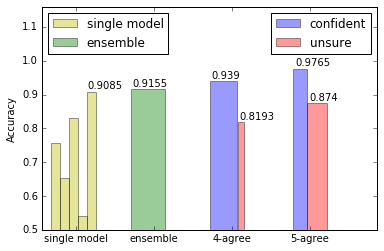

In [216]:
fig, ax = plt.subplots()

four_agree_c = (0.9390, 0.8035)  ## the second is the proportion
four_agree_u = (0.8193, 0.1965)

five_agree_c = (0.9765, 0.405)
five_agree_u = (0.8740, 0.595)

bar_width = 0.3
opacity = 0.4

thin_bar = 0.08
original_acc = [0.7575, 0.654, 0.832, 0.54, 0.9085]

for i in range(len(original_acc)):
    if i == 0:
        rects0 = plt.bar(thin_bar*(i+1), original_acc[i], thin_bar, alpha=opacity, color='y', label='single model')
    else:
        plt.bar(thin_bar*(i+1), original_acc[i], thin_bar, alpha=opacity, color='y')

    
rects1 = plt.bar(0.5+bar_width, 0.9155, bar_width, alpha=opacity, color='g', label='ensemble')
rects2 = plt.bar(1.2+bar_width, four_agree_c[0], four_agree_c[1]*bar_width,  alpha=opacity, color='b', label='confident')
rects3 = plt.bar(1.15+bar_width*2, four_agree_u[0], four_agree_u[1]*bar_width,  alpha=opacity, color='r', label='unsure')
plt.bar(1.95+bar_width, five_agree_c[0], five_agree_c[1]*bar_width,  alpha=opacity, color='b')
plt.bar(2.07+bar_width, five_agree_u[0], five_agree_u[1]*bar_width,  alpha=opacity, color='r')


plt.ylabel('Accuracy')
ax.set_ylim([0.5,1.16])

first_legend = plt.legend(handles=[rects0,rects1], loc=2)
axx = plt.gca().add_artist(first_legend)
second_legend = plt.legend(handles=[rects2,rects3], loc=1)


ind = np.array([0.3,1,1.7,2.4])
plt.xticks(ind, ('single model', 'ensemble', '4-agree', '5-agree'))

cnt = 0
for p in ax.patches:
    if cnt >= 4:
        ax.annotate(str(float(p.get_height())), (p.get_x() * 1.01, p.get_height() * 1.01))
    cnt += 1
plt.savefig('ensemble_confidence_plot.pdf')